In [1]:
# 结构信息

In [2]:
import torch
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import time

In [3]:
dof=5  #结构自由度
dt=0.02 #时间步长度
beta=0.25 
gama=0.5
alpha=0.2 #刚度折减系数

In [4]:
#质量矩阵
m=torch.tensor([5000.0,5000.0,5000.0,5000.0,5000.0])  # kg
M=torch.diag(m)

In [5]:
#刚度矩阵
k=torch.tensor([1e7,1e7,1e7,1e7,1e7])  #层间刚度 N/m
K0=torch.tensor([
    [k[0]+k[1],-k[1],0,0,0],
    [-k[1],k[1]+k[2],-k[2],0,0],
    [0,-k[2],k[2]+k[3],-k[3],0],
    [0,0,-k[2],k[3]+k[4],-k[4]],
    [0,0,0,-k[4],k[4]]
])

In [6]:
K_re=torch.tensor([
    [-k[0],k[1],0,0,0],
    [0,-k[1],k[2],0,0],
    [0,0,-k[2],k[3],0],
    [0,0,0,-k[3],k[4]],
    [0,0,0,0,-k[4]]])

In [7]:
zeta = 0.02; w1 = 0.4479; w2 = 1.16   #定义结构阻尼比，1、2阶频率 9层
a_coe = 2*w1*w2*zeta/(w1+w2); b_coe = 2*zeta/(w1+w2)
C =a_coe*M + b_coe*K0  #计算瑞利阻尼

In [8]:
# Newmark_beta法计算系数
a0=1/(beta*dt**2)
a1=1/(beta*dt)
a2=1/(2*beta)-1
a3=gama/(beta*dt)
a4=gama/beta-1
a5=(gama/beta-2)*dt/2

In [9]:
L=torch.zeros((dof,dof+1))
L[:,0]=m
L[:,1:]=-torch.eye(dof)

In [10]:
H=torch.zeros((dof*2,dof*2))
H[dof:,:dof]=-torch.inverse(M)@K0
H[:dof,dof:]=torch.eye(dof)
H[dof:,dof:]=-torch.inverse(M)@C

In [11]:
W=torch.zeros((dof*2,dof+1))
W[dof:]=torch.inverse(M)@L

In [12]:
S1=torch.zeros((dof*2,dof*2))
S1[:dof,:dof]=a3*torch.eye(dof)
S1[dof:,:dof]=a0*torch.eye(dof)

In [13]:
S2=torch.zeros((dof*2,dof*2))
S2[:dof,:dof]=a4*torch.eye(dof)
S2[dof:,:dof]=a1*torch.eye(dof)
S2[:dof,dof:]=a5*torch.eye(dof)
S2[dof:,dof:]=a2*torch.eye(dof)

In [14]:
Q1=-torch.inverse((H-S1))@S2@W

In [15]:
Q2=-torch.inverse((H-S1))@W

In [16]:
T=-torch.inverse(H-S1)@(S1+S2@H)

In [17]:
A1_1=Q2
A2_1=T@Q2+Q1
A=torch.stack((A1_1,A2_1))
for i in range(2,600):
    A=torch.cat((A,torch.unsqueeze(T@A[-1],0)),dim=0)
A=torch.flip(A,[0])    

In [18]:
A.shape

torch.Size([600, 10, 6])

In [19]:
# 得到P
acc=pd.read_csv("../data/地震加速度.csv")  # m/s^2
acc=torch.tensor(acc.iloc[1:,1:].values)

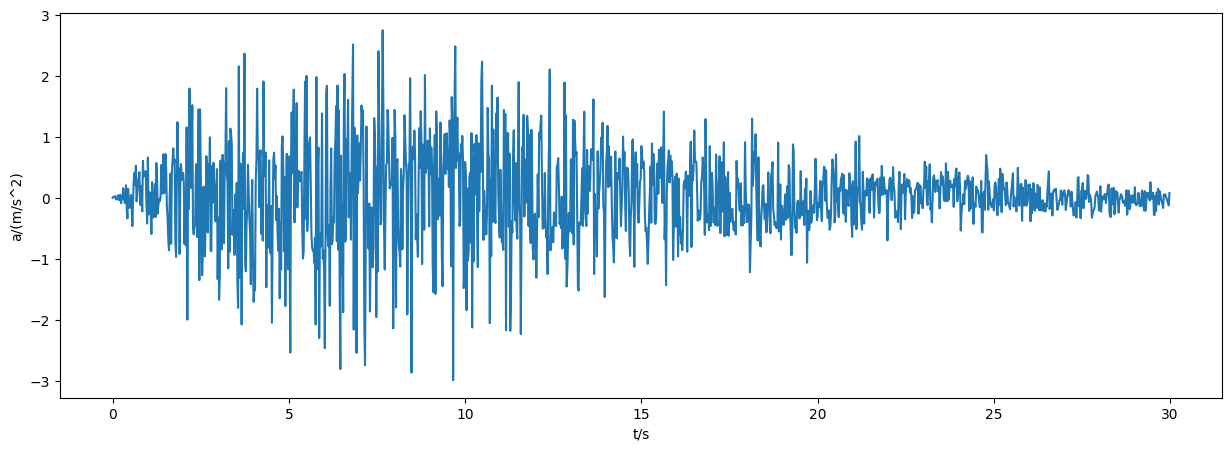

In [20]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,30,0.02),acc[0,:].detach())
plt.ylabel("a/(m/s^2)")
plt.xlabel("t/s")
plt.show()

In [21]:
import torch
import torch.nn as nn

class LSTMModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModule, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # out = self.fc1(out[:, -1, :])
        out = self.fc1(self.relu(out))
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [22]:
# 单层神经网络，无激活函数
class SCL(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,kernel_A):
        super(SCL,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size,stride=1,bias=False)
        self.conv.weight.data = kernel_A
        self.conv.weight.requires_grad = False
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [23]:
#定义损失函数
def V2Fnl(V):
    V_re=torch.zeros_like(V[:,:5,0,:])
    V_re[:,0,:]=V[:,0,0,:]
    V_re[:,1:,:]=V[:,1:5,0,:]-V[:,0:4,0,:]
    Fnl=1000*K_re@(V_re**3)
    return Fnl

In [24]:
a_train=acc[0:170,:].unsqueeze(0)
a_train.shape

torch.Size([1, 170, 1500])

In [25]:
a_train.shape

torch.Size([1, 170, 1500])

In [26]:
get_V_loss=[]
lstm_model=LSTMModule(1,90,3,5)
A_kernel=A.permute((1,2,0)).unsqueeze(1)
scl_model=SCL(1,10,(6,600),A_kernel)
loss=nn.MSELoss()
optimizer=optim.Adam(lstm_model.parameters(),lr=0.01,weight_decay=0.998)

timestamp1=time.time()

for i in range(300):
    optimizer.zero_grad()
    Fnl=lstm_model(a_train.permute((1,2,0)).float())
    P_tatol=torch.cat((a_train.permute((1,2,0)),Fnl),dim=2).permute((0,2,1)).unsqueeze(1)
    P_tatol=torch.cat((torch.zeros([170, 1, 6, 599]),P_tatol),dim=3)
    V=scl_model(P_tatol.float())
    Fnl_re=V2Fnl(V)
    V_loss=loss(Fnl.permute((0,2,1)),Fnl_re)
    V_loss.backward()
    get_V_loss.append(V_loss)
    optimizer.step()

timestamp2=time.time()
time_difference = timestamp2 - timestamp1
print("时间差（秒）：", time_difference)

时间差（秒）： 911.89914727211


In [27]:
V[:,:5,0,:].shape

torch.Size([170, 5, 1500])

In [28]:
df=torch.tensor(get_V_loss).detach().numpy()
df=pd.DataFrame(df)
df.to_csv("get_V_loss.csv")
torch.save(lstm_model, 'get_V_lstm.pth')

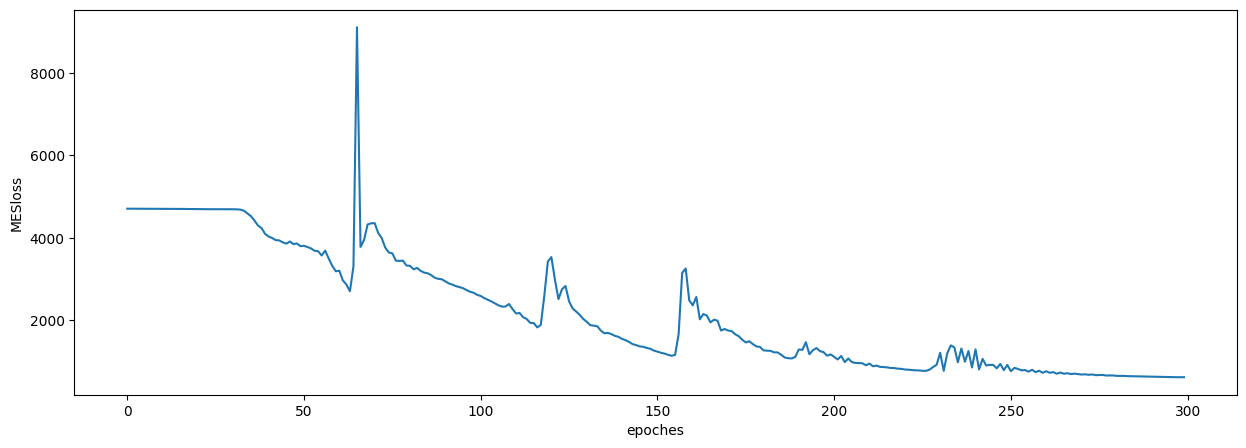

In [29]:
train_loss=pd.read_csv("get_V_loss.csv").iloc[:,1]
plt.figure(figsize=(15,5))
plt.plot(range(300),train_loss)
plt.xlabel("epoches")
plt.ylabel("MESloss")
plt.show()

In [30]:
Fnl=lstm_model(a_train.permute((1,2,0)).float())
P_tatol=torch.cat((a_train.permute((1,2,0)),Fnl),dim=2).permute((0,2,1)).unsqueeze(1)
P_tatol=torch.cat((torch.zeros([170, 1, 6, 599]),P_tatol),dim=3)
V=scl_model(P_tatol.float())
Fnl_re=V2Fnl(V)

In [31]:
V.shape

torch.Size([170, 10, 1, 1500])

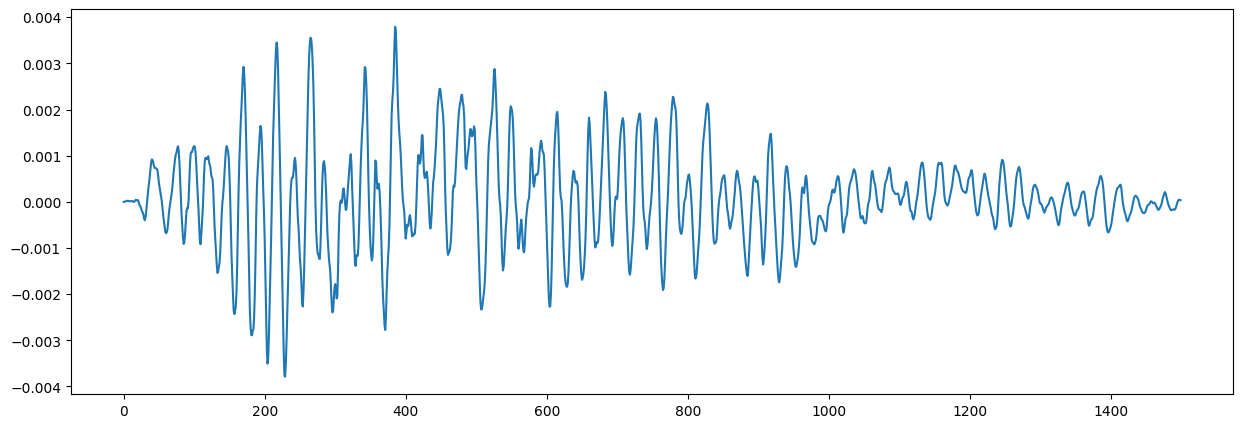

In [32]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),V[1,0,0,:].detach())

In [33]:
Fnl_re[0,0,:].shape

torch.Size([1500])

In [34]:
Fnl.shape

torch.Size([170, 1500, 5])

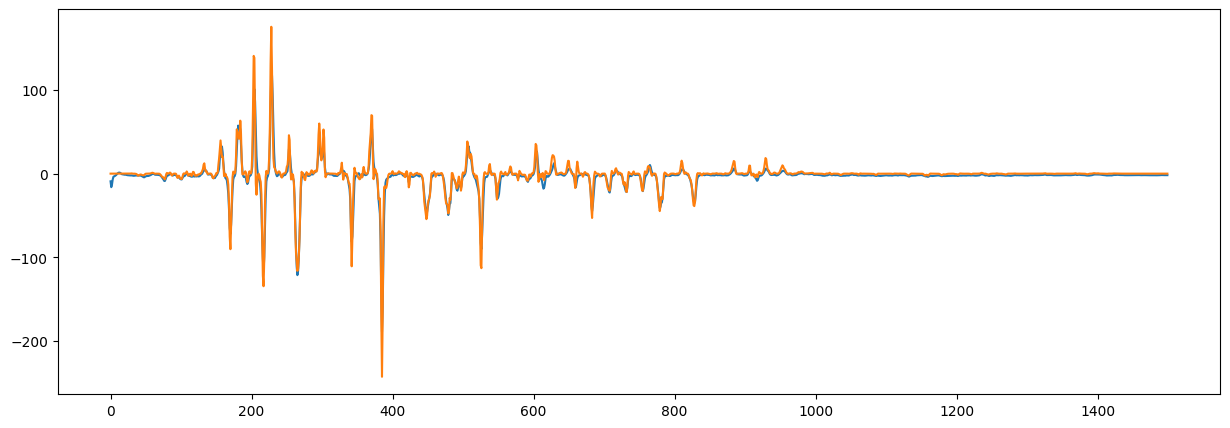

In [35]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),Fnl.permute((0,2,1))[2,0,:].detach())
plt.plot(range(1500),Fnl_re[2,0,:].detach())